<a href="https://colab.research.google.com/github/piygot5/Customer-Insights-Pack-POC/blob/main/topic_modelling_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json, os, uuid
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MOUNT_DIR = '/content/drive/MyDrive/BarclaysReviews/'
DATA_DIR = '/content/drive/MyDrive/BarclaysReviews/data/'
MODEL_DIR = '/content/drive/MyDrive/BarclaysReviews/model/'


In [ ]:
def saveFileToDrive(path,dataframe):

  with open(path, 'w', encoding = 'utf-8-sig') as f:
    dataframe.to_csv(f)
    print("Saving file : "+path)

In [ ]:
final_merged_reviews = pd.read_csv(DATA_DIR+"final_merged_reviews_cleaned.csv")

FileNotFoundError: ignored

In [ ]:
pd.set_option('display.max_colwidth', -1)
# final_merged_reviews[final_merged_reviews["cleaned_data"].notnull() & final_merged_reviews["cleaned_data"].str.contains("reward")][["review_description", "source","rating"]].rating.value_counts()
final_merged_reviews[final_merged_reviews["cleaned_data"].notnull() & final_merged_reviews["cleaned_data"].str.contains("blue")][["review_description", "source","rating"]].shape

(49, 3)

In [ ]:
import spacy 
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
barclays_stop_list = ['app', 'barclays','need','will','pay','work']
stop_words.extend(barclays_stop_list)
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

import re
wnl = WordNetLemmatizer()
def tokenizer(text):
    regex_num_ponctuation = '(\d+)|([^\w\s])'
    regex_little_words = r'(\b\w{1,2}\b)'
    return [wnl.lemmatize(token.lemma_.lower()) for token in nlp(text) if not token.is_stop and not token.is_punct ]

def LemmaTokenizer(doc):
      wnl = WordNetLemmatizer()
      regex_num_ponctuation = '(\d+)|([^\w\s])'
      regex_little_words = r'(\b\w{1,2}\b)'
      return [wnl.lemmatize(t) for t in word_tokenize(doc) 
              if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t) and not t.is_stop and not t.is_punct]

In [ ]:
!pip install lda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.9/320.9 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for lda: filename=lda-2.0.0-cp310-cp310-linux_x86_64.whl size=628185 sha256=9b913f7370c6d84e910ef000b818d3fe3d15fed4b15f52dbc5ea84e7aa76be73
  Stored in directory: /root/.cache/pip/wheels/9d/32/fa/07fdf278a0b24269ce4d0be3d642c28dd0e888a4c5f2031279
Successfully built lda


In [ ]:
!pip install umap-learn

In [ ]:
!pip install sentence-transformers
!pip install transformers

In [ ]:
!pip install HDBSCAN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for HDBSCAN: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541544 sha256=863a6e63ba7a08725840b72a70c725d0985f7abf2d4fe2063c4714f2ab8e6954
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac071b82950f91649d62d72f7f56
Successfully built HDBSCAN


In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 55.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
    

In [ ]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
from bertopic import BERTopic

In [ ]:
import time

In [ ]:
def topicModellingBERT(df,columns, textCol = "cleaned_data",min_df=4,max_features = 10000,min_cluster_size=80,top_n_words=5,path="",model_name="",replace_dict={}):
  print(columns)
  if bool(columns):
    # print("columns")
    for key in columns:
      # print(df.shape)
      df = df[df[key].str.contains(columns[key])]

  umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
  hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=40,
                        gen_min_span_tree=True,
                        prediction_data=True)
  min_df = min_df # minimum required occurences of a word, e.g 4
  max_features = max_features # max number of unique words, e.g 10000

  # vectorizer_model = CountVectorizer(
  #               min_df=min_df, 
  #               max_features=max_features, 
  #               tokenizer=tokenizer, # use tokenizer we defined before
  #               ngram_range=(1,2),
  #               stop_words=stop_words) # we use unigram & bigram
  # X = vectorizer.fit_transform(final_merged_reviews_not_null['review_description'])


  df = df[df[textCol].notnull()]
  if bool(replace_dict):
    df[textCol].replace(replace_dict,inplace=True,regex=True) 
  print('dataet length: ',df.shape,'\n')
  # # we add this to remove stopwords that can pollute topcs
  vectorizer_model = CountVectorizer(ngram_range=(1, 2), min_df=min_df,max_features=max_features)
  df.reset_index(drop=True, inplace=True)
  model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
  )
  topics, probs = model.fit_transform(df[textCol])
  print(model.get_topic_info())

  custom_labels = []
  custom_labels_temp = model.generate_topic_labels(nr_words=1)
  # negative_custom_labels.type
  for i in custom_labels_temp:
    custom_labels.append(i.split('_')[1])
  model.set_topic_labels(custom_labels)

  model.save(path+model_name+'_'+str(int(time.time())))
  return  df,topics, probs, model



In [ ]:
negative_model = BERTopic.load(MODEL_DIR+'negative_sentiment_version_2')
negative_model.get_topic_info()

,Topic,Count,Name,CustomName
0,-1,2243,-1_slow_account_bad_payment,slow
1,0,1246,0_contactless_payment_contactless payment_slow,contactless
2,1,604,1_account_slow_money_login,account
3,2,496,2_crash_calendar_calendar_view_notification,crash
4,3,471,3_update_slow_phone_new,update
5,4,463,4_cheque_photo_picture_slow,cheque
6,5,423,5_chat_slow_service_help,chat
7,6,123,6_navigate_fscs_open_crash,navigate
8,7,103,7_notification_money_payment_spend,notification


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


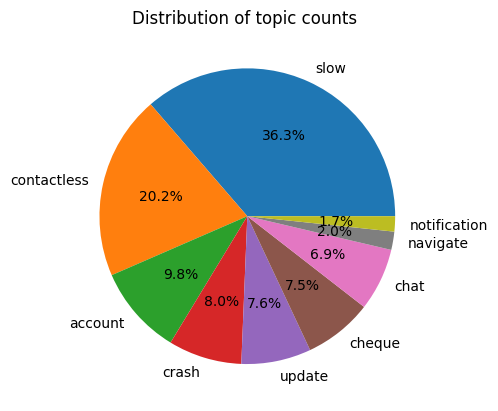

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
MODEL_DIR = '/content/drive/MyDrive/BarclaysReviews/model/'
negative_model = BERTopic.load(MODEL_DIR+'negative_sentiment_version_2')
model_data = negative_model.get_topic_info()

plt.pie(model_data['Count'], labels=model_data['CustomName'], autopct="%1.1f%%")
plt.title("Distribution of topic counts ")
plt.show()

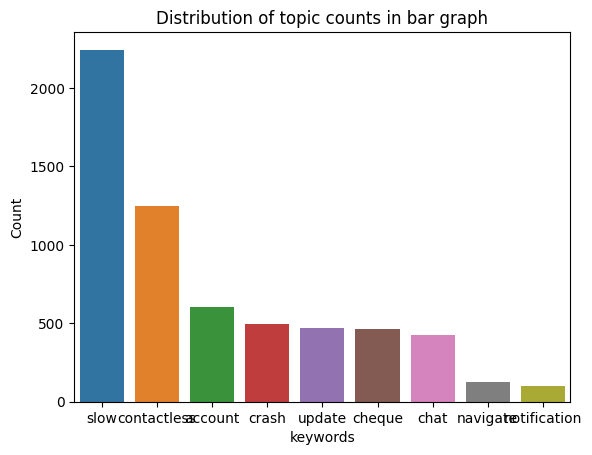

In [ ]:
sns.barplot(data=model_data, x='CustomName', y= 'Count') 


plt.title("Distribution of topic counts in bar graph")
plt.xlabel("keywords")
plt.show()

In [ ]:
df = pd.read_csv(DATA_DIR+"final_merged_reviews_cleaned.csv")
df = df[df['customer_sentiment'].str.contains('NEGATIVE') & df['cleaned_data'].notnull()]
df.reset_index(drop=True, inplace=True)
df_topics = negative_model.get_document_info(df['cleaned_data'])

In [ ]:
word_count_per_topic = {}
topics = df_topics['Topic']
documents = df_topics['Document']
from collections import Counter

for topic in range(-1,df_topics.Topic.nunique()-1):
    # Get the indices of documents belonging to this topic
    indices = [i for i, t in enumerate(topics) if t == topic]
    # Flatten the list of documents belonging to this topic
    words = [word for doc in [documents[i] for i in indices] for word in doc.split()]
    # Count the occurrences of each word in this topic
    word_counts = Counter(words)
    # Add the word count for this topic to the dictionary
    word_count_per_topic[topic] = word_counts

keys = list(word_count_per_topic.keys())
values = list(word_count_per_topic.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

# Print the word count per topic
for topic, word_counts in sorted_dict.items():
    print(f"Topic {topic}: {word_counts}")

Topic -1: Counter({'slow': 884, 'account': 500, 'payment': 482, 'bad': 469, 'phone': 355, 'update': 347, 'open': 237, 'login': 234, 'device': 204, 'card': 195, 'help': 192, 'crash': 190, 'change': 179, 'new': 177, 'transaction': 168, 'customer': 166, 'like': 165, 'issue': 154, 'contactless': 153, 'money': 130, 'problem': 126, 'service': 124, 'screen': 123, 'year': 120, 'option': 119, 'support': 119, 'payee': 117, 'fix': 116, 'detail': 115, 'set': 113, 'month': 110, 'useless': 106, 'tell': 103, 'googlepay': 103, 'day': 102, 'allow': 96, 'access': 96, 'feature': 94, 'close': 94, 'great': 92, 'navigate': 91, 'way': 91, 'load': 90, 'online': 90, 'branch': 90, 'transfer': 87, 'check': 86, 'error': 84, 'look': 84, 'balance': 84, 'number': 84, 'loginin': 83, 'start': 81, 'experience': 77, 'fine': 75, 'people': 74, 'leave': 73, 'download': 73, 'constantly': 73, 'week': 71, 'statement': 71, 'someslow': 70, 'add': 69, 'register': 68, 'message': 67, 'android': 66, 'sort': 66, 'star': 66, 'delete'

In [ ]:
df = pd.read_csv(DATA_DIR+"final_merged_reviews_cleaned.csv")
df,topics, probs, model = topicModellingBERT(df=df,columns= {"customer_sentiment":"NEGATIVE"},path=MODEL_DIR,model_name='negative_topic_modelling',replace_dict={"contactless payment":"contactless"})
 

In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_df, negative_topics,  negative_probs,  negative_model = topicModellingBERT(df=df,columns = {"CustomName":'contactless'}, min_df=2,min_cluster_size=40,path=MODEL_DIR,model_name='negative_topic_1_modelling',replace_dict={"payment":"","slow":"","crash":"","account":""})
#contactless, googlepay , barclaycard,credicard,transfer,money

{'CustomName': 'contactless'}
dataet length:  (1246, 28) 



Batches:   0%|          | 0/39 [00:00<?, ?it/s]

2023-05-01 17:01:21,743 - BERTopic - Transformed documents to Embeddings
2023-05-01 17:01:25,679 - BERTopic - Reduced dimensionality
2023-05-01 17:01:25,766 - BERTopic - Clustered reduced embeddings


   Topic  Count                                         Name
0     -1     81             -1_contactless_gpay_contact_sort
1      0    971              0_contactless_phone_device_card
2      1     98       1_barclaycard_credicard_barclay_update
3      2     96  2_transfer_money_transaction_transfer money


In [ ]:
negative_df, negative_topics,  negative_probs,  negative_model = topicModellingBERT(df=df,columns = {"CustomName":'contactless',"cleaned_data":"contactless"}, min_df=2,min_cluster_size=80,path=MODEL_DIR,model_name='negative_topic_1_modelling',replace_dict={"payment":"","slow":"","crash":"","account":""})


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_Account_df, negative_Account_topics,  negative_Account_probs,  negative_Account_model = topicModellingBERT(df=df,columns = {"CustomName":'account'} ,min_df=2,min_cluster_size=40,path=MODEL_DIR,model_name='negative_topic_account_modelling',replace_dict={"account":"","slow":""})
#login/register , pin,latest_version

{'CustomName': 'account'}
dataet length:  (604, 28) 



Batches:   0%|          | 0/19 [00:00<?, ?it/s]

2023-05-01 10:22:08,355 - BERTopic - Transformed documents to Embeddings
2023-05-01 10:22:11,453 - BERTopic - Reduced dimensionality
2023-05-01 10:22:11,498 - BERTopic - Clustered reduced embeddings


   Topic  Count                                 Name
0 -1      15     -1_saving_lloyd_latest_version_save
1  0      328    0_money_bad_year_payment           
2  1      261    1_login_open_register_device       


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_crash_df, negative_crash_topics,  negative_crash_probs,  negative_crash_model = topicModellingBERT(df=df,columns = {"CustomName":'crash'} ,min_df=2,min_cluster_size=40,path=MODEL_DIR,model_name='negative_topic_crash_modelling',replace_dict={"crash":"","slow":""})
#calender, notification-crash

{'CustomName': 'crash'}
dataet length:  (496, 28) 



Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2023-05-01 10:16:55,978 - BERTopic - Transformed documents to Embeddings
2023-05-01 10:16:58,957 - BERTopic - Reduced dimensionality
2023-05-01 10:16:58,994 - BERTopic - Clustered reduced embeddings


   Topic  Count                                       Name
0 -1      139    -1_constantly_notification_calendar_fix  
1  0      156    0_calendar_view_payment_calendar_calender
2  1      119    1_notification_phone_ped_worke_bad       
3  2      82     2_login_bad_review_constantly            


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_chat_df, negative_chat_topics,  negative_chat_probs,  negative_chat_model = topicModellingBERT(df=df,columns = {"CustomName":'chat'} ,min_df=1,min_cluster_size=5,path=MODEL_DIR,model_name='negative_topic_chat_modelling',replace_dict={"chat":"","slow":""})
#statement ,  service, crash/redirect,download,login 

{'CustomName': 'chat'}
dataet length:  (423, 28) 



Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2023-05-01 17:06:32,798 - BERTopic - Transformed documents to Embeddings
2023-05-01 17:06:35,442 - BERTopic - Reduced dimensionality
2023-05-01 17:06:35,479 - BERTopic - Clustered reduced embeddings


   Topic  Count                                     Name
0     -1    367         -1_help_service_message_customer
1      0     42          0_service_customer_minute_phone
2      1     14  1_service_customer_don_customer service


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/'+"Copy of Negative_topic_modelling_data.csv")
negative_slow_df, negative_slow_topics,  negative_slow_probs,  negative_slow_model = topicModellingBERT(df=df,columns = {"CustomName":'slow'} ,min_df=1,min_cluster_size=30,path=MODEL_DIR,model_name='negative_topic_slow_modelling',replace_dict={"slow":""})
# misc >

{'CustomName': 'slow'}
dataet length:  (2243, 28) 



Batches:   0%|          | 0/71 [00:00<?, ?it/s]

2023-05-02 09:56:31,919 - BERTopic - Transformed documents to Embeddings
2023-05-02 09:56:54,326 - BERTopic - Reduced dimensionality
2023-05-02 09:56:54,522 - BERTopic - Clustered reduced embeddings


   Topic  Count                                                     Name
0 -1      449    -1_bad_update_load_change                              
1  0      1292   0_account_payment_phone_bad                            
2  1      255    1_useless_bad_awful_update                             
3  2      71     2_googlepay_support_support googlepay_googlepay support
4  3      68     3_open_advert_update_open open                         
5  4      60     4_service_customer_customer service_bad                
6  5      48     5_error_load_sign_reset                                


In [ ]:
df = negative_slow_model.get_document_info(negative_slow_df['cleaned_data'])
negative_account_sub_topic_df, negative_account_sub_topics,  negative_account_sub_probs,  negative_account_sub_model = topicModellingBERT(df=df,textCol="Document",columns = {"CustomName":'account'} ,min_df=1,min_cluster_size=30,path=MODEL_DIR,model_name='negative_topic_account_sub_modelling',replace_dict={"account":""})


{'CustomName': 'account'}
dataet length:  (1292, 7) 



Batches:   0%|          | 0/41 [00:00<?, ?it/s]

2023-05-02 10:09:43,222 - BERTopic - Transformed documents to Embeddings
2023-05-02 10:09:50,820 - BERTopic - Reduced dimensionality
2023-05-02 10:09:51,007 - BERTopic - Clustered reduced embeddings


   Topic  Count                            Name
0 -1      159    -1_branch_ipad_business_update
1  0      1071   0_payment_phone_bad_update    
2  1      62     1_mortgage_open_current_close 


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_notification_df, negative_notification_topics,  negative_notification_probs,  negative_notification_model = topicModellingBERT(df=df,columns = {"CustomName":'notification'} ,min_df=1,min_cluster_size=5,path=MODEL_DIR,model_name='negative_topic_notification_modelling',replace_dict={"notification":""})


{'CustomName': 'notification'}
dataet length:  (103, 28) 



Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-05-01 09:59:28,476 - BERTopic - Transformed documents to Embeddings
2023-05-01 09:59:32,690 - BERTopic - Reduced dimensionality
2023-05-01 09:59:32,704 - BERTopic - Clustered reduced embeddings


   Topic  Count                             Name
0 -1      103    -1_payment_money_account_online


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_cheque_df, negative_cheque_topics,  negative_cheque_probs,  negative_cheque_model = topicModellingBERT(df=df,columns = {"CustomName":'cheque'} ,min_df=1,min_cluster_size=5,path=MODEL_DIR,model_name='negative_topic_cheque_modelling',replace_dict={"cheque":""})


{'CustomName': 'cheque'}
dataet length:  (463, 28) 



Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2023-05-01 09:57:38,703 - BERTopic - Transformed documents to Embeddings
2023-05-01 09:57:42,176 - BERTopic - Reduced dimensionality
2023-05-01 09:57:42,241 - BERTopic - Clustered reduced embeddings


   Topic  Count                         Name
0 -1      243    -1_slow_photo_bad_scan     
1  0      202    0_photo_slow_bad_picture   
2  1      18     1_branch_business_slow_tell


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
negative_update_df, negative_update_topics,  negative_update_probs,  negative_update_model = topicModellingBERT(df=df,columns = {"CustomName":'update'} ,min_df=1,min_cluster_size=5,path=MODEL_DIR,model_name='negative_topic_update_modelling',replace_dict={"update":""})


{'CustomName': 'update'}
dataet length:  (471, 28) 



Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2023-05-01 11:13:34,110 - BERTopic - Transformed documents to Embeddings
2023-05-01 11:13:38,243 - BERTopic - Reduced dimensionality
2023-05-01 11:13:38,281 - BERTopic - Clustered reduced embeddings


   Topic  Count                                     Name
0 -1      324    -1_slow_phone_bad_account              
1  0      69     0_crash_slow_open_great                
2  1      40     1_slow_change_bad_access               
3  2      20     2_phone_new_login_reinstall            
4  3      13     3_force_upload_problem_bad             
5  4      5      4_access_auto_google_pixel_access money


In [ ]:
# df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
# negative_navigate_df, negative_navigate_topics,  negative_navigate_probs,  negative_navigate_model = topicModellingBERT(df=df,columns = {"CustomName":'navigate'} ,min_df=1,min_cluster_size=5,path=MODEL_DIR,model_name='negative_topic_navigate_modelling')
negative_navigate_model = BERTopic.load(MODEL_DIR+'negative_topic_navigate_modelling_1682939644')
negative_navigate_model.get_topic_info()

,Topic,Count,Name,CustomName
0,-1,28,-1_phone_android_loginge_welcome,phone
1,0,53,0_crash_account_open_fscs,crash
2,1,42,1_statement_document_slow_simple,statement


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")
pd.set_option('display.max_colwidth', -1)
df[df["cleaned_data"].notnull() & df["cleaned_data"].str.contains("mortgage")][["review_description", "CustomName","source","rating"]]

,review_description,CustomName,source,rating
2,bad experience - error messages despite being up most recent version. not showing my mortgage on the app. limiting my option as to which account to open. not stable at all,slow,Google Play,1
13,slow compared to other banking apps. fundamental functions missing that are supposed to be there. trying to edit monthly mortgage payments but you can't edit monthly payments on the app. app does not contain 'pinsentry' button required to loginin on browser. i can't create a current account because it auto logins me into my mortgage. it closes itself whenever i change to a different app (which i need to do to verify payment from another bank). it is not suitable for mortgage customers.,slow,Google Play,1
191,app has lost my mortgage and now reverse ed to a former address. not sure how well barclays are managing my personal data now.,slow,Google Play,1
269,"it's a nothing special banking app, only doing what every banking app does. one star for insulting our intelligence by telling us it gives us rewards when, in fact, they aren't rewards they are marketing. boots points are rewards, meerkat meals are rewards. 25% off a subscription for a month, then full price is just marketing. as for blue rewards, pay £5 and get £5 back. it is pointless. why buy your mortgage or insurance products when others are cheaper even with your offers? no respect.",notification,Google Play,1
329,"since the last update the app keeps closing down on me while i'm using it. it happened on few customer journeys like checking balance, trying to contact customer service, checking mortgage balance etc. it's so bad. the contact less payments are not reliable for me too so haven't used it for a while now due to being mega embarrassing. if you were supporting at least samsung pay, it would make things so much easier for samsung users.",slow,Google Play,2
...,...,...,...,...
5875,credicard and mortgages transactions display normally. current account is a single column and looks awful. your suggested ‘fix’ is to change my settings to alter the way my entire phone looks. if i do that everything else is too small. there is a reason some of us have to use large text. please allow the current account to display like the other accounts.,slow,App Store,2
5997,"i’m very annoyed at the app and barclays ,it’s so hard to get an up to date statement .. then you have to slow in line on the chat for so slow . and the phone slow is always 20 minutes to india … enter the branch and have sore back from queuing ,and lose 1 say off you life … after i get my mortgage,i’m switch appsing back to the new american bank with the good hours … \n\nthis new wave of bank making us use apps and machines in the walls are horrible . zero stars",chat,App Store,1
6022,this app has not been thought thru for mortgage only customers. taken a week to get registered including a 45 minute phone call slow. they lack the imagination to consider you having a mortgage without their current account. it requires your phone number which is not collected during mortgage application. does not allow you to make lump sum overpayments or set up recurring dd payments. virtually pointless and very badly thought out,slow,App Store,1
6059,"1) i got a mortgage worth barclays and installed the app. i could see some functionality but was told i needed to open a current account to get full functionality (eg changing direct debit collection dates)\n\n2) i opened a current account. \n\n3) my current account did not appear in my app. ok, i think, i’ll remove the app and reinstall. \n\n4) i re-installed the app and plugged in my new current account details … but now there is no sign of the mortgage. there’s no option to link the current account and the mortgage, off ed at least there isn’t one i can see. \n\n5) faqs don’t help, and there’s no obvious online support. \n\ni can’t be the only one with this problem, right guys? \n\nplease help!",slow,App Store,1


In [ ]:
!pip install bert-extractive-summarizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall murmurhash 
!pip uninstall spacy 
!pip install -U spacy
!pip install murmurhash

Found existing installation: murmurhash 1.0.9
Uninstalling murmurhash-1.0.9:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/murmurhash-1.0.9.dist-info/*
    /usr/local/lib/python3.10/dist-packages/murmurhash/*
Proceed (Y/n)? y
  Successfully uninstalled murmurhash-1.0.9
Found existing installation: spacy 3.5.2
Uninstalling spacy-3.5.2:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.10/dist-packages/spacy-3.5.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/spacy/*
Proceed (Y/n)? 

In [ ]:
from summarizer import Summarizer,TransformerSummarizer

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/'+"Copy of Negative_topic_modelling_data.csv")
pd.set_option('display.max_colwidth', -1)


<ipython-input-25-3741bd5a1dff>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
df = df[df["CustomName"].str.contains("contactless") ]
df=df[ df["Probability"]==1.0].head(20)
body =df['review_description'].to_string(index=False)

In [ ]:
df.shape

(20, 28)

In [ ]:
body

'have to echo most of what andrea has said just below as this has been my experience as well. when it works, it works very well and quickly but there are so many moments when it just lets you down. random crashes when idle in a screen, infinite loading, then exactly the same again, had to restart phone to even open the app - i also was left embarrassed at a till because i didn\'t bring my card with me and i was just getting a black screen. there really should never be downslow for a banking app.\nseveral weeks ago the app suddenly crashped working for contactless payments and now just shows a loginon popup stating contactless payments cannot be made with this device (samsung s9). when is this going to be fixed?                                                                                                                                                                                                                                                                                        

In [ ]:
df.dtypes

Unnamed: 0.4               int64  
Unnamed: 0.3               int64  
Unnamed: 0.2               int64  
Unnamed: 0.1               int64  
Unnamed: 0                 int64  
source                     object 
review_id                  object 
user_name                  object 
review_title               object 
review_description         object 
rating                     int64  
thumbs_up                  float64
reviewCreatedVersion       object 
review_date                object 
developer_response         object 
developer_response_date    object 
appVersion                 object 
laguage_code               object 
country_code               object 
customer_sentiment         object 
cleaned_data               object 
Document                   object 
Topic                      int64  
Name                       object 
CustomName                 object 
Top_n_words                object 
Probability                float64
Representative_document    bool   
dtype: object

In [ ]:

bert_model = Summarizer()


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_summary = ''.join(bert_model(body, min_length=60,num_sentences=4))
print(bert_summary)

have to echo most of what andrea has said just below as this has been my experience as well. app updates while i'm on travel, disables contactless payments, helps to call customer support, who end up locking me out of app for 2 weeks.... absolutely useless slow and slow again. i want to use my credicard for contactless, yet still has not been enabled for googlepay whilst their app is broken. when i called got told i was on a block list due to my device and had to be unblocked.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df = pd.read_csv(DATA_DIR+"Negative_topic_modelling_data.csv")


FileNotFoundError: ignored

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/'+"Copy of Negative_topic_modelling_data.csv")


In [ ]:
df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,source,review_id,user_name,review_title,review_description,...,country_code,customer_sentiment,cleaned_data,Document,Topic,Name,CustomName,Top_n_words,Probability,Representative_document
0,0,0,0,0,0,Google Play,092e95ce-ad25-421f-962d-edc0e7921ba3,Clive Silas Wilson,NaN,"now this is awful because a) i can't make payments with my phone, but then b) every slow i open the app i get prompted to change settings so that i can make payments with my phone, and after i've done that it tells me that i can't make payments with my phone. every slow after that when i just want to use the app it holds everything up with a prompt that i can't make payments with my phone!",...,uk,NEGATIVE,awful payment phone slow open prompt change setting payment phone tell payment phone slow hold prompt payment phone,awful payment phone slow open prompt change setting payment phone tell payment phone slow hold prompt payment phone,0,0_contactless_payment_contactless payment_slow,contactless,contactless - payment - contactless payment - slow - device,0.644477,False
1,1,1,1,1,1,Google Play,d4653490-58fd-4f30-8869-6be6f038e00b,Susan gorman,NaN,"crashes all the slow and don't get notifications anymore and contactless payment doesn't work anymore,been over 2 months now.bad app update when is this likely to be sorted out i don't even get notified when money go's in or out now",...,uk,NEGATIVE,crash slow notification anymore contactless payment anymore month bad update likely sort notify money,crash slow notification anymore contactless payment anymore month bad update likely sort notify money,0,0_contactless_payment_contactless payment_slow,contactless,contactless - payment - contactless payment - slow - device,0.596212,False
2,2,5,5,5,5,Google Play,a81418d3-55ae-4050-84a9-d81e8aade700,David Robinson,NaN,bad experience - error messages despite being up most recent version. not showing my mortgage on the app. limiting my option as to which account to open. not stable at all,...,uk,NEGATIVE,bad experience error_message despite recent version mortgage limiting option account open stable,bad experience error_message despite recent version mortgage limiting option account open stable,-1,-1_slow_account_bad_payment,slow,slow - account - bad - payment - phone,0.707730,False
3,3,8,8,8,8,Google Play,63f751a3-7e16-4337-8d31-af892447d795,Gavin Alexander,NaN,"have to echo most of what andrea has said just below as this has been my experience as well. when it works, it works very well and quickly but there are so many moments when it just lets you down. random crashes when idle in a screen, infinite loading, then exactly the same again, had to restart phone to even open the app - i also was left embarrassed at a till because i didn't bring my card with me and i was just getting a black screen. there really should never be downslow for a banking app.",...,uk,NEGATIVE,echo andrea experience quickly moment random crash idle screen infinite loading exactly restart phone open leave embarrassed till bring card black screen downslow,echo andrea experience quickly moment random crash idle screen infinite loading exactly restart phone open leave embarrassed till bring card black screen downslow,0,0_contactless_payment_contactless payment_slow,contactless,contactless - payment - contactless payment - slow - device,1.000000,False
4,4,9,9,9,9,Google Play,86c345b8-16c4-4339-b9f3-d78ddef25e3d,Any Person,NaN,"although the app is good for sorting finances i've always had an issue with contactless, i have to rlepgon every 2-3 days and refresh the settings, now however it won't let me change the settings to allow contactless all together. i get to the screen and try to click ok to authorise it using contactless and nothing happens, it's very bad!",...,uk,NEGATIVE,sort finance issue contactless rlepgon day refresh setting change setting allow contactless screen click authorise contactless happen bad,sort finance issue contactless r

In [ ]:
negative_navigate_model = BERTopic.load(MODEL_DIR+'negative_topic_navigate_modelling_1682939644')
negative_navigate_model.get_topic_info()